In [153]:
%matplotlib inline

import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

In [154]:
img = cv2.cvtColor(cv2.imread('Example Photos/099b331721c6a2a6ed8859d51a5ff091.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
#img = cv2.imread('Example Photos/099b331721c6a2a6ed8859d51a5ff091.jpg', cv2.IMREAD_GRAYSCALE)

In [155]:
imgS = np.copy(img)
#imgS = np.zeros(img.shape, dtype = img.dtype)
imgMask = np.zeros((img.shape[0], img.shape[1]), dtype = np.int8)

In [156]:
def randomPoint(dims):
    return (random.randint(0, dims[0]-1), random.randint(0, dims[1]-1))

In [157]:
def ColourDistance(c1, c2):
    c1 = c1.astype(np.float64)
    c2 = c2.astype(np.float64)
    dR = (c1[0] - c2[0]) * (c1[0] - c2[0])
    dG = (c1[1] - c2[1]) * (c1[1] - c2[1])
    dB = (c1[2] - c2[2]) * (c1[2] - c2[2])
    hr = (c1[0] + c2[0]) / (2 * 256)
    return np.sqrt(((2 + hr) * dR) + (4 * dG) + ((2 + (255/256) - hr) * dB))

def ColourDistanceY(c1, c2):
    c1 = c1.astype(np.float64)
    c2 = c2.astype(np.float64)
    Y1 = 0.299 * c1[0] + 0.587 * c1[1] + 0.114 * c1[2]
    Y2 = 0.299 * c2[0] + 0.587 * c2[1] + 0.114 * c2[2]
    return abs(Y1 - Y2)

def ColourDistanceGray(c1, c2):
    c1 = c1.astype(np.int16)
    c2 = c2.astype(np.int16)
    return abs(c1 - c2)

In [158]:
def AddBoundaryPoints(IMask, pointAdded):
    lis = []
    temp0 = (pointAdded[0]-1, pointAdded[1])
    if((temp0[0] >= 0) and (IMask[temp0] == 0)):
        lis.append(temp0)
        IMask[temp0] = -1
    temp0 = (pointAdded[0]+1, pointAdded[1])
    if((temp0[0] < IMask.shape[0]) and (IMask[temp0] == 0)):
        lis.append(temp0)
        IMask[temp0] = -1
    temp0 = (pointAdded[0], pointAdded[1]-1)
    if((temp0[1] >= 0) and (IMask[temp0] == 0)):
        lis.append(temp0)
        IMask[temp0] = -1
    temp0 = (pointAdded[0], pointAdded[1]+1)
    if((temp0[1] < IMask.shape[1]) and (IMask[temp0] == 0)):
        lis.append(temp0)
        IMask[temp0] = -1
    return lis

In [159]:
def Kernel(p1, p2):
    #fine tune A and B
    A = 20
    B = 30
    dis = np.sqrt((p1[0] - p2[0])*(p1[0] - p2[0]) + (p1[1] - p2[1])*(p1[1] - p2[1]))
    if(dis <= B):
        return -(B/A) * dis + B
    return 0

def KernelAsymp(p1, p2):
    C = 164
    D = 3
    dis = np.sqrt((p1[0] - p2[0])*(p1[0] - p2[0]) + (p1[1] - p2[1])*(p1[1] - p2[1]))
    return C / (dis + D)

def KernelRoot(p1, p2):
    E = 6.3
    F = 40
    rat = (F/E)**2
    dis = np.sqrt((p1[0] - p2[0])*(p1[0] - p2[0]) + (p1[1] - p2[1])*(p1[1] - p2[1]))
    if(dis <= rat):
        return np.sqrt((F*F) - (dis * E * E))
    return 1

In [160]:
def PointCalcDisSort(IMG, lis, avgCol):
    A = []
    for i in range(len(lis)):
        A.append((lis[i], ColourDistance(IMG[lis[i]], avgCol)))
    A.sort(key = lambda a: a[1])
    return A

In [161]:
def AddtoAvgCol(avgC, C1, N):
    C1 = C1.astype(np.float64)
    return ((avgC * N)/(N+1)) + (C1  / (N+1))

In [162]:
def AddtoAvgPos(avgP, P1, N):
    return (((avgP[0] * N) + P1[0] ) / (N+1), ((avgP[1] * N) + P1[1] ) / (N+1))

In [163]:
RandPointLen = 100000
RandPoints = [randomPoint(imgMask.shape) for x in range(RandPointLen)]

SizData = []

#RandPointLen = 1
#RandPoints = [(75, 165)]

for k in range(1, RandPointLen+1):
    
    #find point
    point = RandPoints[k-1]
    if(imgMask[point] != 0):
        continue
    #print(point)

    #Array Memory
    toReset = []
    toAvgCol = [point]
    
    #Colour Region From point
    avgPos = point
    avgCol = img[point].astype(np.float64)
    Boundary = AddBoundaryPoints(imgMask, point)
    imgMask[point] = 1
    siz = 1
    while(len(Boundary) > 0):
        bPoint = Boundary[0]
        dis = ColourDistanceY(avgCol, img[bPoint])
        #print(bPoint, avgCol, img[bPoint], dis)
        if(dis < Kernel(bPoint, avgPos)):
            imgMask[bPoint] = 1
            avgCol = AddtoAvgCol(avgCol, img[bPoint], siz)
            avgPos = AddtoAvgPos(avgPos, bPoint, siz)
            BAdds = AddBoundaryPoints(imgMask, bPoint)
            Boundary += BAdds
            siz += 1
            toAvgCol.append(bPoint)
        if(imgMask[bPoint] == -1):
            toReset.append(bPoint)
        Boundary = Boundary[1:]

    SizData.append(siz)
    if(siz <= 000):
        toReset += toAvgCol
        toAvgCol = []
        SizData = SizData[:-1]
        
    for P in toReset:
        imgMask[P] = 0
    for P in toAvgCol:
        imgS[P] = avgCol
    


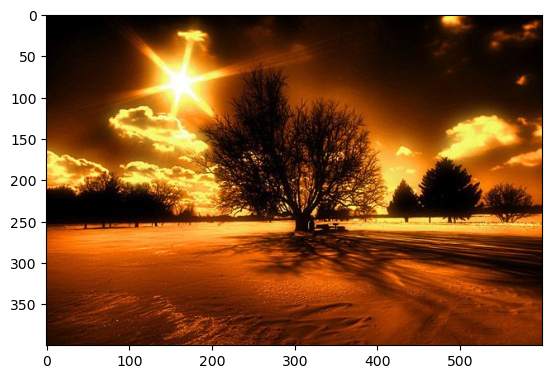

In [164]:
plt.imshow(img)

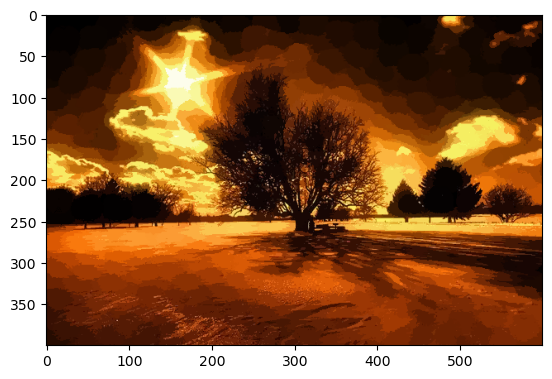

In [165]:
plt.imshow(imgS)

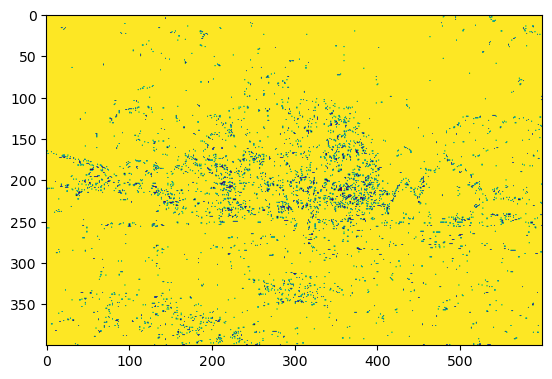

In [166]:
plt.imshow(imgMask)

In [167]:
#cv2.imwrite('Example Photos/Fin3W.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
#cv2.imwrite('Example Photos/Fin3X.jpg', cv2.cvtColor(imgS, cv2.COLOR_RGB2BGR))